In [1]:
import os
import pandas as pd
import random as rd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from skimage.io import imread
import warnings
warnings.filterwarnings('ignore')

from skimage.transform import rescale
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Flatten, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

## Data Preprocessing:

In [2]:
data_dir = 'data/images/Train'
data_df = pd.read_csv('data/train.csv')
test_dir = 'data/images/Test_Unlabeled/'
test_df = pd.read_csv('data/test.csv')

img_width, img_height = 2048, 1365
new_scale = .30

In [3]:
data_df.tail()

image_id  healthy  multiple_diseases  rust  scab
1816  Train_1816        0                  0     0     1
1817  Train_1817        1                  0     0     0
1818  Train_1818        1                  0     0     0
1819  Train_1819        0                  0     1     0
1820  Train_1820        0                  0     0     1

In [ ]:
data_df.columns

Index(['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab'], dtype='object')

In [ ]:
# Make two-column dataframe of the different health classifications of the training/test sets
data_df['plant_health'] = data_df.apply(lambda x: 'healthy' if x['healthy'] == 1 else (
                                            'multiple_diseases' if x['multiple_diseases'] == 1 else (
                                            'rust' if x['rust'] == 1 else ('scab'))), axis=1)
data_df = data_df[['image_id', 'plant_health']].copy()
data_df['image_id'] = data_df['image_id'].apply(lambda x: x +'.jpg')
data_df.head()

image_id       plant_health
0  Train_0.jpg               scab
1  Train_1.jpg  multiple_diseases
2  Train_2.jpg            healthy
3  Train_3.jpg               rust
4  Train_4.jpg            healthy

In [ ]:
data_df['plant_health'].value_counts()

rust                 622
scab                 592
healthy              516
multiple_diseases     91
Name: plant_health, dtype: int64

In [ ]:
# Prep ImageDataGenerator to upsample all categories until there is an equal amount of each category
def gen_img(df, iterations, category, dir=data_dir, width=img_width, height=img_height):
  newimage_datagen = ImageDataGenerator(
      rotation_range=30,
      brightness_range=(.75, 1.25),
      fill_mode='nearest',
      horizontal_flip=True,
      vertical_flip=True
  )
  # Save new images to same directory that they are being generated from
  upsample_generator = newimage_datagen.flow_from_dataframe(
      dataframe=df,
      directory=dir,
      target_size=(height, width),
      batch_size=1,
      save_to_dir=dir,
      save_prefix=category,
      save_format='jpg',
      shuffle=False,
      x_col='image_id',
      y_col='plant_health',

  )


  # Makes dataframe of labels to include id and health categorization of each new image generated
  new_file = os.listdir(path=dir)
  single_df = pd.DataFrame(columns = ['image_id', 'plant_health'])
  i = 0
  for batches in upsample_generator:
    files = os.listdir(path=dir)
    for f in files:
      if f not in new_file:
        if i % len(df) == 0:
          limiter = 0 # Limiter in place to keep dataframe from 
        temp_dict = {'image_id':f, 'plant_health':df['plant_health'][limiter]}
        temp_df = pd.DataFrame([temp_dict], columns=temp_dict.keys())
        single_df = pd.concat([single_df, temp_df], axis=0)
        new_file.append(f)
    i += 1      
    limiter += 1
    if i == iterations:
      break
  return single_df

In [ ]:
def disp_img(df, dir=data_dir):
  blank_gen = ImageDataGenerator(rescale=1./ 255)
  get_img = blank_gen.flow_from_dataframe(
      batch_size=1,
      dataframe=df,
      directory=dir,
      shuffle=True,
      target_size=(round(img_height*.3), round(img_width*.3)),
      x_col='image_id',
      y_col='plant_health'
  )
  
  f = plt.figure(figsize=(15,4))
  ax = f.add_subplot(141)
  ax2 = f.add_subplot(142)
  ax3 = f.add_subplot(143)
  ax4 = f.add_subplot(144)

  batch = get_img.next()
  image = batch[0].reshape(round(img_height*.3), round(img_width*.3), 3)
  ax.imshow(image, aspect='auto')

  batch = get_img.next()
  image2 = batch[0].reshape(round(img_height*.3), round(img_width*.3), 3)
  ax2.imshow(image2, aspect='auto')

  batch = get_img.next()
  image3 = batch[0].reshape(round(img_height*.3), round(img_width*.3), 3)
  ax3.imshow(image3, aspect='auto')

  batch = get_img.next()
  image4 = batch[0].reshape(round(img_height*.3), round(img_width*.3), 3)
  ax4.imshow(image4, aspect='auto')
  plt.show()
  return get_img


In [ ]:
# Generate images using the function from the cell above to upsample minority cases
highest_value = data_df['plant_health'].value_counts().max()
categories = data_df['plant_health'].unique()

for c in categories:
  categorical_df = data_df[data_df['plant_health'] == c].copy().reset_index(drop=True)

  if len(categorical_df) < highest_value:
    iters = highest_value - len(categorical_df)
    temp_df = gen_img(df=categorical_df, iterations=iters, category=c)
    data_df = pd.concat([data_df,temp_df], axis=0).reset_index(drop=True)
data_df['plant_health'].value_counts()

Found 592 validated image filenames belonging to 1 classes.
Found 91 validated image filenames belonging to 1 classes.
Found 516 validated image filenames belonging to 1 classes.


healthy              622
rust                 622
multiple_diseases    622
scab                 622
Name: plant_health, dtype: int64

----Sample Original Image, Plant Health: scab----
Found 592 validated image filenames belonging to 1 classes.


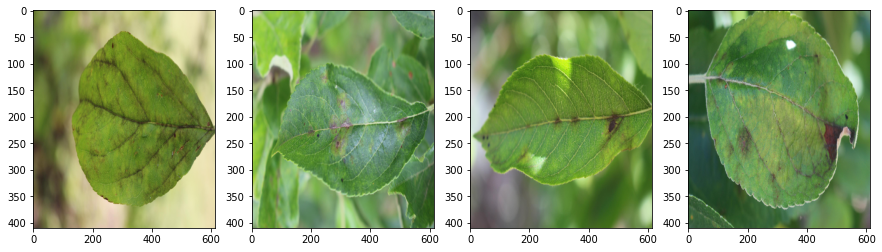

----Sample Generated Image, Plant Health: scab----
Found 30 validated image filenames belonging to 1 classes.


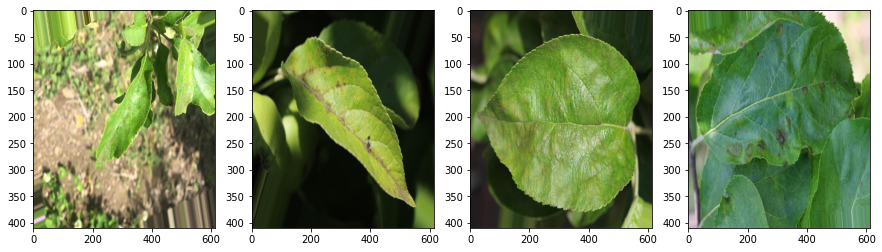

----Sample Original Image, Plant Health: multiple_diseases----
Found 91 validated image filenames belonging to 1 classes.


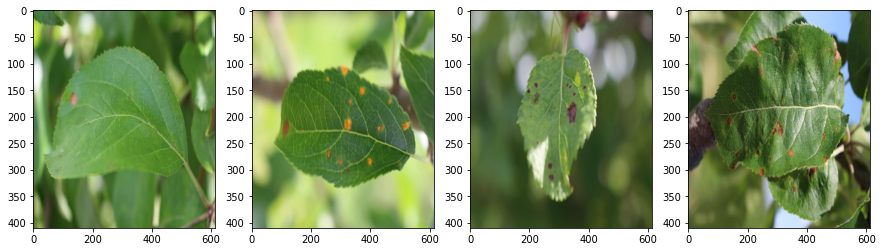

----Sample Generated Image, Plant Health: multiple_diseases----
Found 531 validated image filenames belonging to 1 classes.


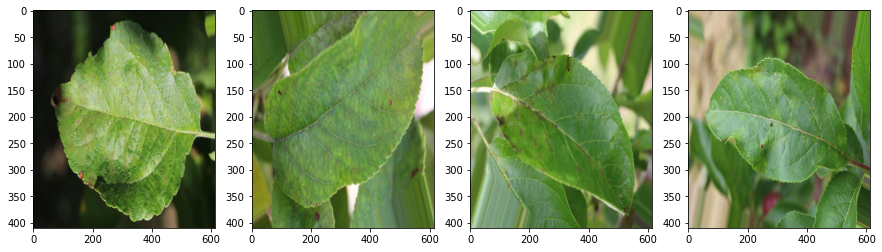

----Sample Original Image, Plant Health: healthy----
Found 516 validated image filenames belonging to 1 classes.


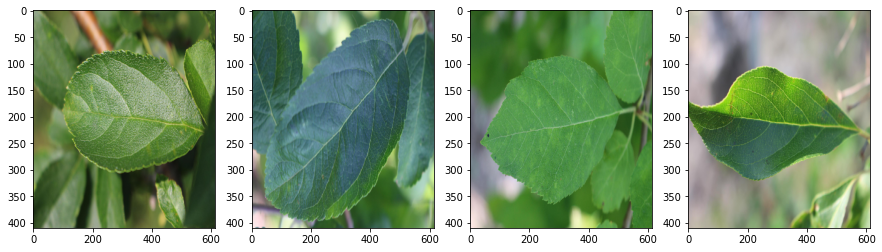

----Sample Generated Image, Plant Health: healthy----
Found 106 validated image filenames belonging to 1 classes.


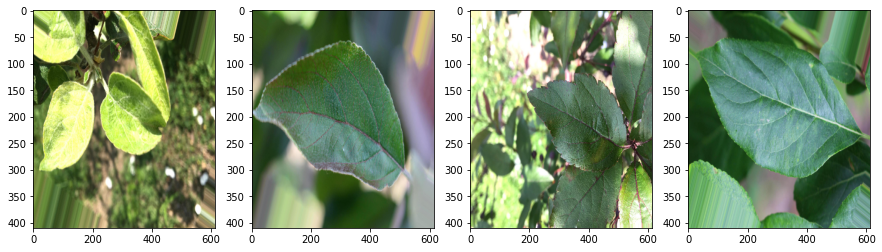

----Sample Original Image, Plant Health: rust----
Found 622 validated image filenames belonging to 1 classes.


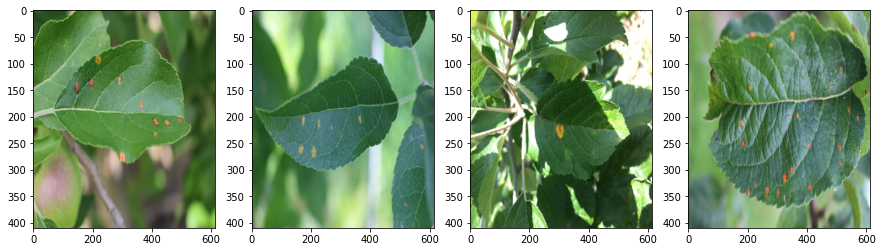

----No Generated Image, Plant Health: rust----


In [ ]:
# Display Both Original and Generated Samples 
for c in categories:
  categorical = data_df[data_df['plant_health'] == c].copy().reset_index(drop=True)
  categorical['img_split'] = categorical.apply(lambda x: True if c in x['image_id'] else False, axis=1)
  orimg_df = categorical[categorical['img_split'] == False].copy().reset_index(drop=True)
  geimg_df = categorical[categorical['img_split'] == True].copy().reset_index(drop=True)
  print('----Sample Original Image, Plant Health: ' + c + '----')
  disp_img(df=orimg_df)
  
  
  if len(orimg_df) < highest_value: 
    print('----Sample Generated Image, Plant Health: ' + c + '----')
    disp_img(df=geimg_df)
  else:
    print('----No Generated Image, Plant Health: ' + c + '----')
    

In [ ]:
categorical = data_df[data_df['plant_health'] == 'healthy'].copy().reset_index(drop=True)
categorical['img_split'] = categorical.apply(lambda x: True if 'healthy' in x['image_id'] else False, axis=1)
orimg_df = categorical[categorical['img_split'] == False].copy().reset_index(drop=True)
disp_img(df=orimg_df)

fig = 
fig.show()

## Deep Learning CNN Models with Categorical Classification:

#### Use various parameter tunings to increase accuracy of apple leaf health classification models. Leaf picture can be classified into one of four categories: healthy, multiple diseases, rust, scab.

In [ ]:
# Create train and test generator parameters for output images
split_size = 0.20
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    rescale= 1./ 255,
    validation_split=split_size,
    zoom_range=0.2)

test_datagen = ImageDataGenerator(rescale=1./ 255)

In [ ]:
batch_size = 10
new_scale = .25

def get_generators(df, test_df=test_df, train_datagen=train_datagen, test_datagen=test_datagen,
                   img_width=img_width, img_height=img_height, batch_size=batch_size,
                   scale=new_scale, class_mode='categorical'):
  train_generator = train_datagen.flow_from_dataframe(
  dataframe=df, 
  directory=data_dir,
  interpolation='nearest',
  x_col='image_id',
  y_col='plant_health',
  subset='training',
  target_size=(round(img_height*scale), round(img_width*scale)),
  batch_size=batch_size,
  shuffle=True,
  class_mode=class_mode
  )
  validation_generator = train_datagen.flow_from_dataframe(
  dataframe=df, 
  directory=data_dir,
  interpolation='nearest',
  x_col='image_id',
  y_col='plant_health',
  subset='validation',
  target_size=(round(img_height*scale), round(img_width*scale)),
  batch_size=batch_size,
  shuffle=True,
  class_mode=class_mode
  )
  test_generator = test_datagen.flow_from_dataframe(
  dataframe=test_df,
  directory=test_dir,
  interpolation='nearest',
  x_col="image_id",
  y_col=None,
  target_size=(round(img_height*scale), round(img_width*scale)),
  batch_size=batch_size,
  shuffle=False,
  class_mode=None
  )
  return train_generator, test_generator, validation_generator

In [ ]:
# fit generators with main data
train_generator, test_generator, validation_generator = get_generators(df=data_df)

Found 1991 validated image filenames belonging to 4 classes.
Found 497 validated image filenames belonging to 4 classes.
Found 0 validated image filenames.


In [ ]:
train_samples = round(len(data_df)*(1-split_size))
validation_samples = round(len(data_df)*split_size)
starting_node_length = (img_width)//8
input_shape = (round(img_height*new_scale), round(img_width*new_scale), 3)

def make_model(df, num, model_num, Activation='relu', Activation2='softmax', Padding='valid', Optimizer='rmsprop', Loss='categorical_crossentropy',
               output=4, Generator=train_generator, Validation_data=validation_generator, split_size=split_size, snl=starting_node_length,
               train_samples=train_samples, validation_samples=validation_samples, batch_size=batch_size, input_shape=input_shape):
  model = Sequential()
  model.add(Conv2D(starting_node_length, (3,3), padding=Padding, input_shape=input_shape, activation=Activation))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))
  
  model.add(Conv2D(starting_node_length//2, (3,3), padding=Padding, activation=Activation))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))
  
  model.add(Conv2D(starting_node_length//2, (3,3), padding=Padding, activation=Activation))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))
  
  model.add(Conv2D(starting_node_length//2, (3,3), padding=Padding, activation=Activation))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))
  
  model.add(Conv2D(128, (3,3), padding=Padding, activation=Activation))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))
  
  model.add(Conv2D(256, (3,3), padding=Padding, activation=Activation))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))
  
  model.add(Flatten())
  model.add(Dense(512, activation=Activation))
  model.add(Dropout(0.5))
  model.add(Dense(output, activation=Activation2))
  
  model.compile(optimizer=Optimizer,
              loss=Loss,
              metrics=['accuracy'])
  
  history = model.fit_generator(generator=Generator,
            validation_data=Validation_data,
            epochs=15,
            verbose=1,
            steps_per_epoch=train_samples//batch_size,
            validation_steps=validation_samples//batch_size
            )
  model.save_weights(f'/content/drive/My Drive/capstone4/data/models/{num}_{model_num}.h5')
  parameters = {'activation':Activation, 'optimizer':Optimizer, 'padding':Padding}
  return history, parameters

In [ ]:
activations = ['relu', 'tanh', 'sigmoid']
optimizers = ['sgd', 'adam', 'rmsprop']
paddings = ['valid', 'same']

In [ ]:
# Shuffle the Main Dataframe
shuf = list(data_df.index)
rd.shuffle(shuf)
data_df = data_df.iloc[shuf].copy().reset_index(drop=True)

In [ ]:
# Run various deep learnig models using different parameter tunings. Train each one on 15 epochs and save results to list
history_list = []
parameters_list = []
model_num = 0
for a in activations:
  for o in optimizers:
    for p in paddings:
        history, parameters = make_model(df=data_df, num=1, model_num=model_num, Activation=a, Padding=p, Optimizer=o)
        model_num += 1
        history_list.append(history)
        parameters_list.append(parameters)

Epoch 1/15
199/199 [==============================] - 172s 864ms/step - loss: 1.3932 - accuracy: 0.2549 - val_loss: 1.3863 - val_accuracy: 0.2776
Epoch 2/15
199/199 [==============================] - 168s 844ms/step - loss: 1.3884 - accuracy: 0.2615 - val_loss: 1.3850 - val_accuracy: 0.2857
Epoch 3/15
199/199 [==============================] - 172s 864ms/step - loss: 1.3865 - accuracy: 0.2600 - val_loss: 1.3864 - val_accuracy: 0.2510
Epoch 4/15
199/199 [==============================] - 171s 860ms/step - loss: 1.3868 - accuracy: 0.2585 - val_loss: 1.3868 - val_accuracy: 0.2469
Epoch 5/15
199/199 [==============================] - 171s 858ms/step - loss: 1.3866 - accuracy: 0.2615 - val_loss: 1.3867 - val_accuracy: 0.2224
Epoch 6/15
199/199 [==============================] - 173s 870ms/step - loss: 1.3832 - accuracy: 0.2761 - val_loss: 1.3878 - val_accuracy: 0.2224
Epoch 7/15
199/199 [==============================] - 170s 856ms/step - loss: 1.3832 - accuracy: 0.2670 - val_loss: 1.3863 -

In [ ]:
# Make Dataframe of the Average Results of the Last 3 Epochs for Each Model
d_list1 = []
d_list2 = []
for i in range(len(parameters_list)):
    dict1 = {'accuracy':np.mean(history_list[i].history['accuracy'][-3:]),
                'val_accuracy':np.mean(history_list[i].history['val_accuracy'][-3:]),
                'loss':np.mean(history_list[i].history['loss'][-3:]),
                'val_loss':np.mean(history_list[i].history['val_loss'][-3:])}
    d_list1.append(dict1)
    d_list2.append(parameters_list[i])
    
df1 =  pd.DataFrame(d_list1)
df2 = pd.DataFrame(d_list2)

df3 = pd.concat([df1, df2], axis=1)
df3.tail(3)

accuracy  val_accuracy      loss  val_loss activation optimizer padding
15  0.247013      0.254422  1.431462  1.410093    sigmoid      adam    same
16  0.248528      0.248299  1.416580  1.397412    sigmoid   rmsprop   valid
17  0.246340      0.239456  1.436554  1.415789    sigmoid   rmsprop    same

In [ ]:
# Sort Values by Validation Accuracy and Add a Column to Look for Overfitting
df3['diff_accuracies_%'] = 100 * abs(df3['accuracy'] - df3['val_accuracy']) / df3['val_accuracy']
df3.sort_values('val_accuracy', ascending=False, inplace=True)
df3.head()

accuracy  val_accuracy      loss  ...  optimizer padding diff_accuracies_%
4  0.744573      0.751701  0.665746  ...    rmsprop   valid          0.948152
5  0.597173      0.638095  0.942343  ...    rmsprop    same          6.413160
7  0.422682      0.427891  1.258834  ...        sgd    same          1.217372
6  0.409557      0.393878  1.279571  ...        sgd   valid          3.980911
0  0.319367      0.295918  1.357202  ...        sgd   valid          7.924133

[5 rows x 8 columns]

In [ ]:
# Graph the Results
sort00 = df3.index[0]
sort01 = df3.index[1]
sort02 = df3.index[2]

x_values = np.arange(0, len(history_list[0].history['val_accuracy']), 1)
vac0 = history_list[sort00].history['val_accuracy'] * 100
vac1 = history_list[sort01].history['val_accuracy'] * 100
vac2 = history_list[sort02].history['val_accuracy'] * 100

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_values, y=vac0,
                         mode='lines+markers',
                         name='model_num:' + str(sort00)))
fig.add_trace(go.Scatter(x=x_values, y=vac1,
                         mode='lines+markers',
                         name='model_num:' + str(sort01)))
fig.add_trace(go.Scatter(x=x_values, y=vac2,
                         mode='lines+markers',
                         name='model_num:' + str(sort02)))
fig.update_layout(title_text='CNN: Validation Accuracy per Epoch',
                  xaxis_title='Epochs', yaxis_title='Val Acc %')
fig.show()

In [ ]:
re_sort = df3.sort_values('accuracy', ascending=False)


In [ ]:
re_sort.head()

accuracy  val_accuracy      loss  ...  optimizer padding diff_accuracies_%
4  0.744573      0.751701  0.665746  ...    rmsprop   valid          0.948152
5  0.597173      0.638095  0.942343  ...    rmsprop    same          6.413160
7  0.422682      0.427891  1.258834  ...        sgd    same          1.217372
6  0.409557      0.393878  1.279571  ...        sgd   valid          3.980911
1  0.334175      0.222449  1.345277  ...        sgd    same         50.225310

[5 rows x 8 columns]

In [ ]:
# Graph the Results
sort10 = re_sort.index[0]
sort11 = re_sort.index[1]
sort12 = re_sort.index[2]

x_values = np.arange(0, len(history_list[0].history['accuracy']), 1)
ac0 = history_list[sort10].history['accuracy'] * 100
ac1 = history_list[sort11].history['accuracy'] * 100
ac2 = history_list[sort12].history['accuracy'] * 100

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_values, y=ac0,
                         mode='lines+markers',
                         name='model_num:' + str(sort10)))
fig.add_trace(go.Scatter(x=x_values, y=ac1,
                         mode='lines+markers',
                         name='model_num:' + str(sort11)))
fig.add_trace(go.Scatter(x=x_values, y=ac2,
                         mode='lines+markers',
                         name='model_num:' + str(sort12)))
fig.update_layout(title='CNN: Accuracy per Epoch',
                  xaxis_title='Epochs', yaxis_title='Acc %')
fig.show()

### Categorical Classification Using DenseNet121

In [ ]:
model = Sequential()
model.add(DenseNet121(input_shape=input_shape,
                      weights='imagenet',
                      include_top=False))
model.add(GlobalAveragePooling2D())
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['categorical_accuracy'])
model.summary()              

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 10, 16, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
dense_51 (Dense)             (None, 4)                 4100      
Total params: 7,041,604
Trainable params: 6,957,956
Non-trainable params: 83,648
_________________________________________________________________


In [ ]:
history2 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // batch_size
)

Epoch 1/15
199/199 [==============================] - 176s 886ms/step - loss: 0.8178 - categorical_accuracy: 0.6946 - val_loss: 1.2206 - val_categorical_accuracy: 0.4837
Epoch 2/15
199/199 [==============================] - 170s 855ms/step - loss: 0.5900 - categorical_accuracy: 0.7673 - val_loss: 0.7100 - val_categorical_accuracy: 0.7735
Epoch 3/15
199/199 [==============================] - 171s 857ms/step - loss: 0.4905 - categorical_accuracy: 0.8334 - val_loss: 0.9091 - val_categorical_accuracy: 0.7510
Epoch 4/15
199/199 [==============================] - 173s 872ms/step - loss: 0.4982 - categorical_accuracy: 0.8168 - val_loss: 1.3480 - val_categorical_accuracy: 0.7000
Epoch 5/15
199/199 [==============================] - 172s 864ms/step - loss: 0.4608 - categorical_accuracy: 0.8279 - val_loss: 0.7094 - val_categorical_accuracy: 0.7714
Epoch 6/15
199/199 [==============================] - 172s 862ms/step - loss: 0.3735 - categorical_accuracy: 0.8713 - val_loss: 0.9637 - val_categoric

In [ ]:
model.save_weights('/content/drive/My Drive/capstone4/data/models/2_0.h5')

In [ ]:
# Graph the Results
x_values = np.arange(0, len(history2.history['val_categorical_accuracy']), 1)
vac = history2.history['val_categorical_accuracy']  * 100

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_values, y=vac,
                         mode='lines+markers',
                         name='model_num:' + str(sort00)))
fig.update_layout(title_text='Dense121: Validation Categorical Accuracy per Epoch',
                  xaxis_title='Epochs', yaxis_title='Val Acc %')
fig.show()

In [ ]:
print('val_acc: ' + str(history2.history['val_categorical_accuracy'][-1]) + ", acc: " + str(history2.history['categorical_accuracy'][-1]))

val_acc: 0.8142856955528259, acc: 0.9257950782775879


In [ ]:
x_values = np.arange(0, len(history2.history['categorical_accuracy']), 1)
ac = history2.history['categorical_accuracy']  * 100

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_values, y=ac,
                         mode='lines+markers',
                         name='model_num:' + str(sort00)))
fig.update_layout(title_text='Dense121: Categorical Accuracy per Epoch',
                  xaxis_title='Epochs', yaxis_title='Val Acc %')
fig.show()

## Deep Learning CNN Models with Binary Classification:

In [ ]:
# Make New Dataframe With Plant Health Being Represented as Binary: Healthy/Unhealthy 
data_df['binary_plant_health'] = data_df.apply(lambda x: 'healthy' if x['plant_health'] == 'healthy' else 'unhealthy', axis=1)
data_df2 = data_df[['image_id', 'binary_plant_health']].copy()
data_df2['binary_plant_health'].value_counts()

unhealthy    1866
healthy       622
Name: binary_plant_health, dtype: int64

In [ ]:
# Create Dataframe of Equal Length Classified Categories: Healthy and Unhealthy 
healthy = data_df2[data_df2['binary_plant_health'] == 'healthy'].copy()
unhealthy = data_df2[data_df2['binary_plant_health'] == 'unhealthy'].copy()


shuffle_list = list(unhealthy.index)
rd.shuffle(shuffle_list)
unhealthy = data_df2.iloc[shuffle_list[:len(healthy)]].copy()

# Shuffle Data
binary_df = pd.concat([healthy, unhealthy], axis=0).reset_index(drop=True)
binary_df.rename({'image_id':'image_id', 'binary_plant_health':'plant_health'}, axis=1, inplace=True)
shuffle_list2 = list(binary_df.index)
rd.shuffle(shuffle_list2)
binary_df = binary_df.iloc[shuffle_list2].copy().reset_index(drop=True)
print(binary_df['plant_health'].value_counts())
print('-------')
print(binary_df.tail(10))

healthy      622
unhealthy    622
Name: plant_health, dtype: int64
-------
            image_id plant_health
1234  Train_1489.jpg      healthy
1235   Train_604.jpg    unhealthy
1236   Train_746.jpg      healthy
1237  Train_1711.jpg    unhealthy
1238   Train_592.jpg      healthy
1239   Train_391.jpg    unhealthy
1240   Train_595.jpg      healthy
1241  Train_1674.jpg    unhealthy
1242   Train_701.jpg      healthy
1243    Train_75.jpg    unhealthy


----Sample Plant Health: Healthy----
Found 622 validated image filenames belonging to 1 classes.


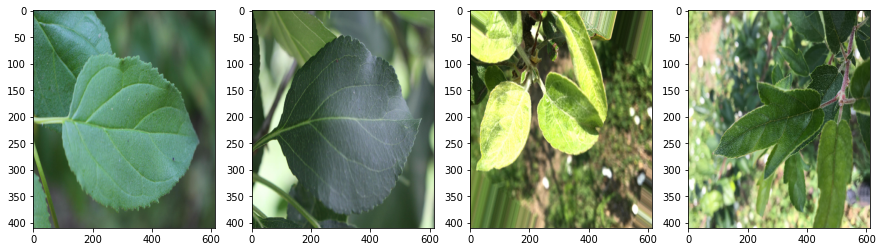

----Sample Plant Health: Unhealthy----
Found 622 validated image filenames belonging to 1 classes.


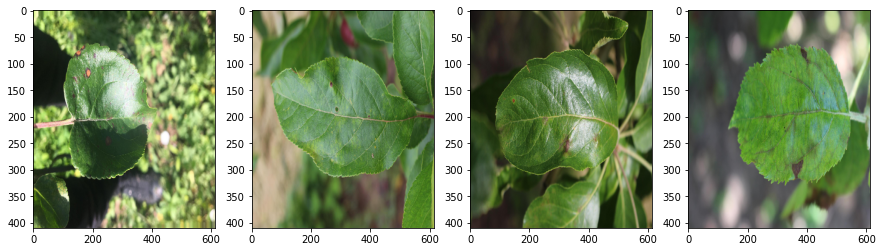

In [ ]:
health_df = binary_df[binary_df['plant_health'] == 'healthy'].copy().reset_index(drop=True)
unhealth_df = binary_df[binary_df['plant_health'] == 'unhealthy'].copy().reset_index(drop=True)
print('----Sample Plant Health: Healthy----')
disp_img(df=health_df)

print('----Sample Plant Health: Unhealthy----')
disp_img(df=unhealth_df)


In [ ]:
# Set New Batch Sizes to Scale with New Dataframe then Make Generators
train_batch_size = len(binary_df)//28
test_batch_size = len(test_df)//28
new_scale = .25
input_shape = (round(img_height*new_scale), round(img_width*new_scale), 3)
print(train_batch_size)

train_generator, test_generator, validation_generator = get_generators(df=binary_df, class_mode='binary')

44
Found 996 validated image filenames belonging to 2 classes.
Found 248 validated image filenames belonging to 2 classes.
Found 0 validated image filenames.


In [ ]:
# Setup binary classification model using the DenseNet121 pretrained model
model = Sequential()
model.add(DenseNet121(input_shape=input_shape,
                      weights='imagenet',
                      include_top=False))
model.add(GlobalAveragePooling2D())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss = 'binary_crossentropy',
              metrics=['accuracy'])
model.summary()

29089792/29084464 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 12, 19, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________


In [ ]:
# Save history of model for comparison
history3 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // batch_size
)

Epoch 1/15
99/99 [==============================] - 453s 5s/step - loss: 0.4349 - accuracy: 0.8347 - val_loss: 0.7693 - val_accuracy: 0.7000
Epoch 2/15
99/99 [==============================] - 82s 830ms/step - loss: 0.3234 - accuracy: 0.8682 - val_loss: 2.1274 - val_accuracy: 0.6708
Epoch 3/15
99/99 [==============================] - 82s 829ms/step - loss: 0.2243 - accuracy: 0.9219 - val_loss: 0.2327 - val_accuracy: 0.9125
Epoch 4/15
99/99 [==============================] - 82s 832ms/step - loss: 0.2979 - accuracy: 0.8783 - val_loss: 0.1660 - val_accuracy: 0.9292
Epoch 5/15
99/99 [==============================] - 82s 830ms/step - loss: 0.2226 - accuracy: 0.9168 - val_loss: 0.5315 - val_accuracy: 0.6833
Epoch 6/15
99/99 [==============================] - 82s 825ms/step - loss: 0.2153 - accuracy: 0.9239 - val_loss: 0.3140 - val_accuracy: 0.8583
Epoch 7/15
99/99 [==============================] - 81s 823ms/step - loss: 0.2449 - accuracy: 0.9067 - val_loss: 0.1373 - val_accuracy: 0.9458
E

In [ ]:
model.save_weights('/content/drive/My Drive/capstone4/data/models/3_0.h5')

In [ ]:
print('val_acc: ' + str(history3.history['val_accuracy'][-1]) + ", acc: " + str(history3.history['accuracy'][-1]))

val_acc: 0.9458333253860474, acc: 0.9482758641242981


In [ ]:
x_values = np.arange(0, len(history3.history['accuracy']), 1)
ac = history3.history['accuracy']  * 100

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_values, y=ac,
                         mode='lines+markers'))
fig.update_layout(title_text='Binary Categorization Dense121: Accuracy per Epoch',
                  xaxis_title='Epochs', yaxis_title='Acc %')
fig.show()

In [ ]:
x_values = np.arange(0, len(history3.history['val_accuracy']), 1)
vac = history3.history['val_accuracy']  * 100

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_values, y=vac,
                         mode='lines+markers'))
fig.update_layout(title_text='Binary Cateogirzation Dense121: Validation Accuracy per Epoch',
                  xaxis_title='Epochs', yaxis_title='Val Acc %')
fig.show()

In [ ]:
# Fit Models and Store Results in Lists
# binary_history_list = []
# binary_parameters_list = []
# model_num = 0
# for a in activations:
#   for o in optimizers:
#     for p in paddings:
#         history4, parameters4 = make_model(df=binary_df, num=4, model_num=model_num, Activation=a, Activation2='sigmoid', Padding=p, Optimizer=o, output=1, Loss='binary_crossentropy')
#         model_num += 1
#         binary_history_list.append(history4)
#         binary_parameters_list.append(parameters4)
#         print(history3.history['val_accuracy'][-1], parameters4)

In [ ]:
# x_values = np.arange(0, len(history4.history['accuracy']), 1)
# ac = history4.history['accuracy']  * 100

# fig = go.Figure()
# fig.add_trace(go.Scatter(x=x_values, y=ac,
#                          mode='lines+markers',
#                          name='model_num:' + str(sort00)))
# fig.update_layout(title_text='Binary Categorization Dense121: Accuracy per Epoch',
#                   xaxis_title='Epochs', yaxis_title='Acc %')
# fig.show()

In [ ]:
# x_values = np.arange(0, len(history4.history['val_accuracy']), 1)
# vac = history4.history['val_accuracy']  * 100

# fig = go.Figure()
# fig.add_trace(go.Scatter(x=x_values, y=vac,
#                          mode='lines+markers',
#                          name='model_num:' + str(sort00)))
# fig.update_layout(title_text='Binary Cateogirzation Dense121: Validation Accuracy per Epoch',
#                   xaxis_title='Epochs', yaxis_title='Val Acc %')
# fig.show()

## Results:

#### The DenseNet121 transferred learning models outperformed the CNNs built from scratch, even without tweaking the hyperparameters of the DenseNet models. The task of health classification is accurate enough to make good classification judgement ~90% of the time, but when limiting the models to predict only binary classifications, the validation accuracy climbed to nearly 95% in only 15 epochs with very little overfitting (binary classification of the plants may only be usely for flagging which plants might need special attention). This means any predicted output is likely to be correct often enough to deploy into an app/program designed with the end user in mind. Managing unhealthy plants quickly could save more of the crop and waste less food to disease.